# Unet with Fastai


In [1]:
import os
import sys
import random

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import fastai
from fastai.vision import *
import torch

from util import mask2rle, rle2mask


In [2]:
# const
data_path = '../../data/siim-pneumothorax'
path = Path(data_path)

data_split_path = './SIIM_5-FOLD'

torch.cuda.set_device('cuda:1')

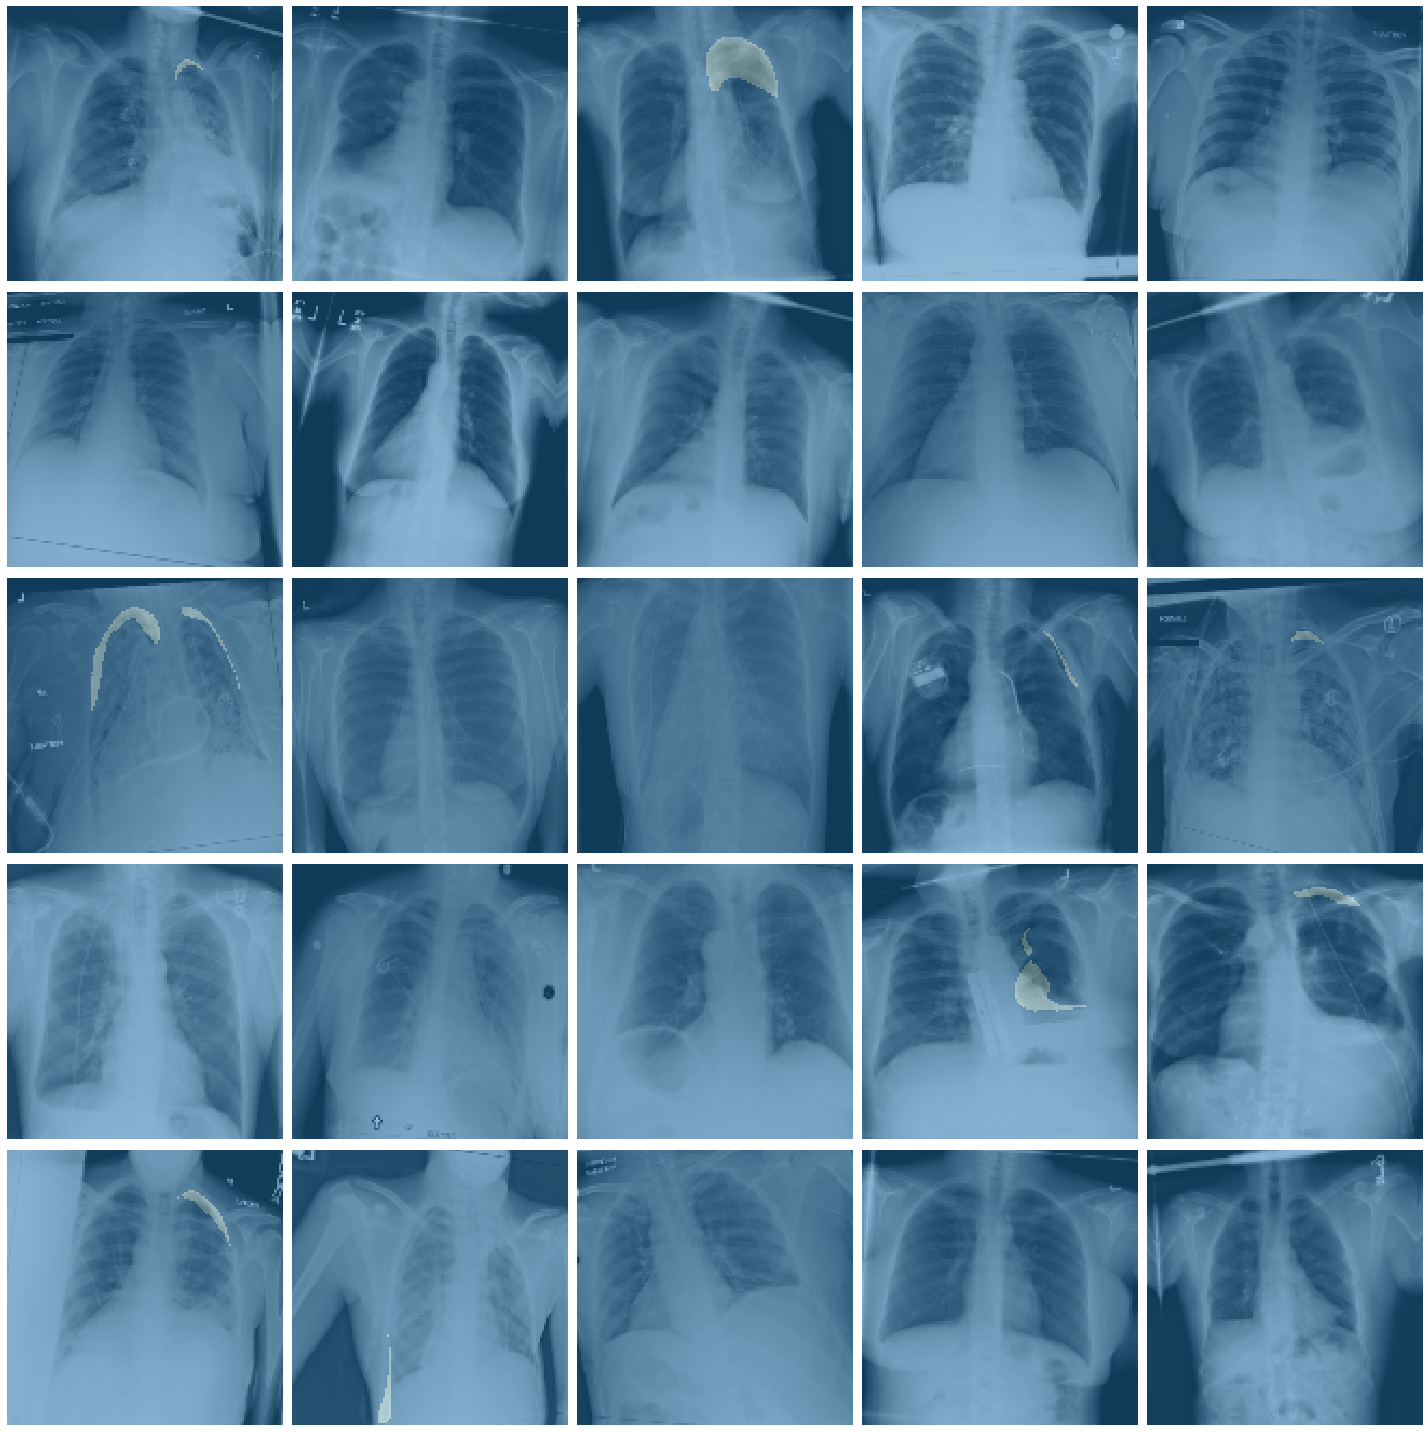

In [8]:
# data

# Setting div=True in open_mask
class SegmentationLabelList(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)
    
class SegmentationItemList(SegmentationItemList):
    _label_cls = SegmentationLabelList
    
# Setting transformations on masks to False on test set
def transform(self, tfms:Optional[Tuple[TfmList,TfmList]]=(None,None), **kwargs):
    if not tfms: tfms=(None,None)
    assert is_listy(tfms) and len(tfms) == 2
    self.train.transform(tfms[0], **kwargs)
    self.valid.transform(tfms[1], **kwargs)
    kwargs['tfm_y'] = False # Test data has no labels
    if self.test: self.test.transform(tfms[1], **kwargs)
    return self
fastai.data_block.ItemLists.transform = transform

# Create databunch
data = (SegmentationItemList.from_csv(path=path, csv_name='{}/all-0.csv'.format(data_split_path))
        .split_by_fname_file('SIIM_5-FOLD/val-0.csv')
        .label_from_func(lambda x : str(x).replace('train_png', 'mask_png'), classes=[0, 1])
        .add_test((path/'test_png').ls(), label=None)
        .transform(get_transforms(), size=128, tfm_y=True)
        .databunch(path=Path('.'), bs=64)
        .normalize(imagenet_stats))

data.show_batch()


In [5]:
# Create U-Net with a pretrained resnet34 as encoder
learn = unet_learner(data, models.resnet34, metrics=[dice])


In [6]:
# Fit one cycle of 6 epochs with max lr of 1e-3
learn.fit_one_cycle(6, slice(1e-3))


epoch,train_loss,valid_loss,dice,time
0,0.019573,0.014694,0.000000,03:05
1,0.015883,0.014094,0.000000,01:33
2,0.014386,0.012282,0.003022,01:34
3,0.012762,0.012966,0.013176,01:33
4,0.011863,0.010578,0.201098,01:32
5,0.011091,0.010485,0.225278,01:33


In [7]:
# Unfreeze the encoder (resnet34)
learn.unfreeze()

# Fit one cycle of 12 epochs
learn.fit_one_cycle(12, slice(3e-5, 3e-4))


epoch,train_loss,valid_loss,dice,time
0,0.010616,0.010484,0.196236,01:34
1,0.011248,0.010702,0.144854,01:33
2,0.011630,0.010683,0.267040,01:33
3,0.010950,0.010311,0.217184,01:33
4,0.011249,0.010982,0.188447,01:33
5,0.010663,0.010091,0.236403,01:33
6,0.010071,0.010484,0.280135,01:33
7,0.009698,0.010080,0.336616,01:33
8,0.009096,0.010045,0.263492,01:33
9,0.008590,0.009811,0.292586,01:34


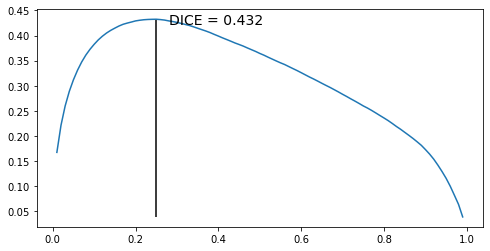

In [9]:
# Predictions for the validation set
preds, ys = learn.get_preds()
preds = preds[:,1,...]
ys = ys.squeeze()

def dice_overall(preds, targs):
    n = preds.shape[0]
    preds = preds.view(-1)
    targs = targs.view(-1)
    intersect = (preds * targs).sum(-1).float()
    union = (preds+targs).sum(-1).float()
    return (2. * intersect / union)

# Find optimal threshold
dices = []
thrs = np.arange(0.01, 1, 0.01)
for i in progress_bar(thrs):
    preds_m = (preds>i).long()
    dices.append(dice_overall(preds_m, ys).mean())
dices = np.array(dices)

best_dice = dices.max()
best_thr = thrs[dices.argmax()]

plt.figure(figsize=(8,4))

plt.plot(thrs, dices)
plt.vlines(x=best_thr, ymin=dices.min(), ymax=dices.max())
plt.text(best_thr+0.03, best_dice-0.01, f'DICE = {best_dice:.3f}', fontsize=14);

plt.show()


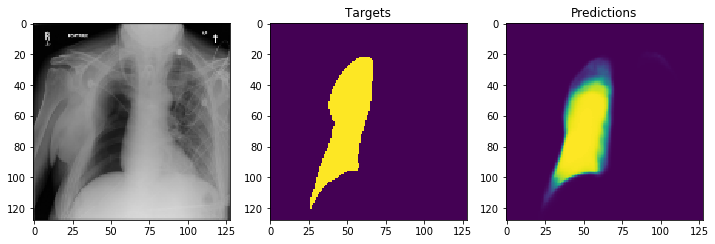

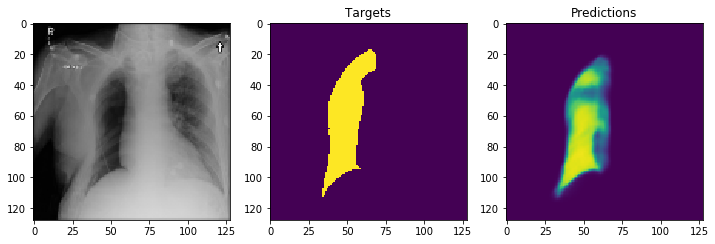

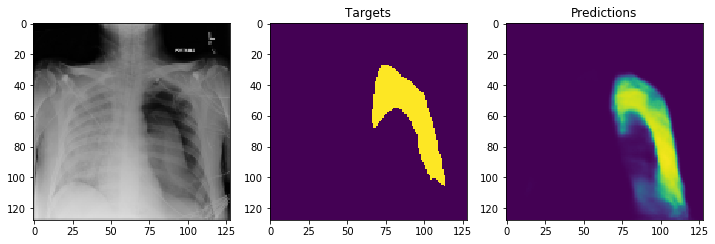

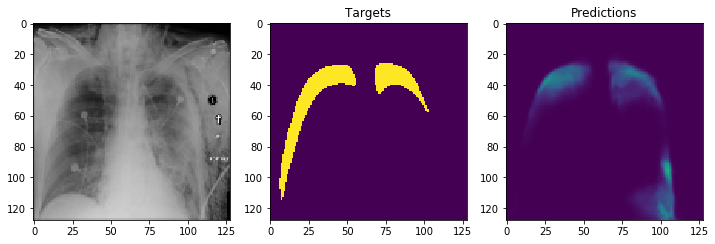

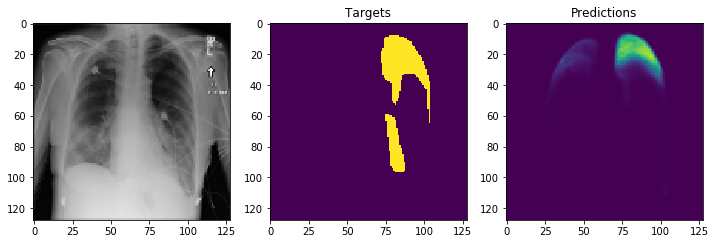

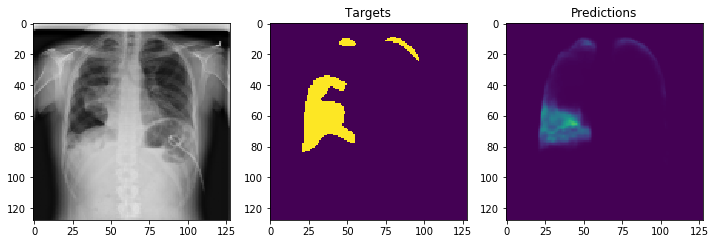

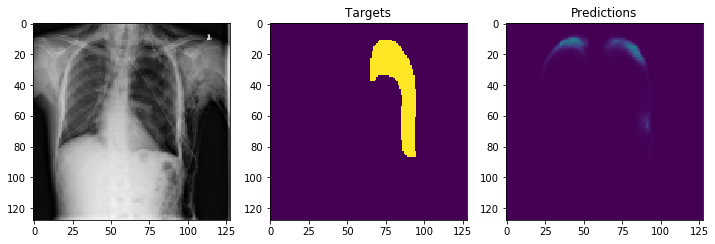

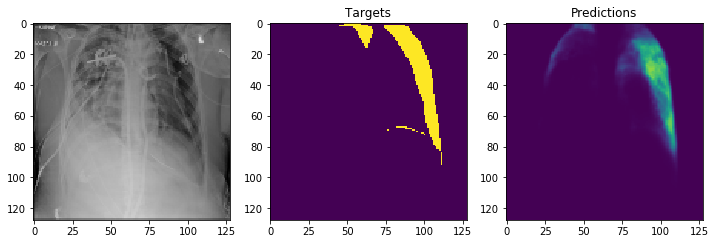

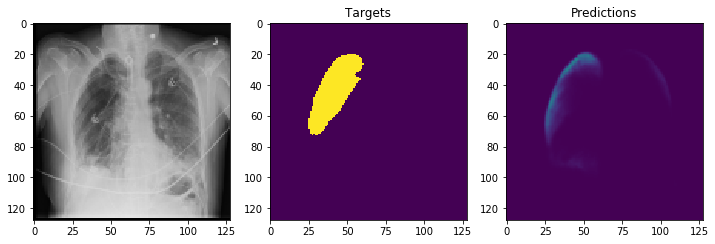

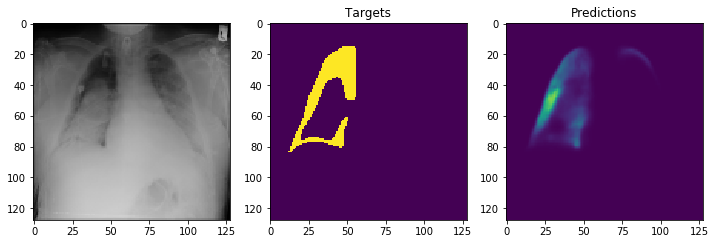

In [10]:
# Plot some samples
rows = 10
plot_idx = ys.sum((1,2)).sort(descending=True).indices[:rows]

for idx in plot_idx:
    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 4))
    
    ax0.imshow(data.valid_ds[idx][0].data.numpy().transpose(1,2,0))
    ax1.imshow(ys[idx], vmin=0, vmax=1)
    ax2.imshow(preds[idx], vmin=0, vmax=1)
    
    ax1.set_title('Targets')
    ax2.set_title('Predictions')
    

In [11]:
# Predictions for test set
preds, _ = learn.get_preds(ds_type=DatasetType.Test)
preds = (preds[:,1,...]>best_thr).long().numpy()


In [12]:
# Generate rle encodings (images are first converted to the original size)
rles = []
for p in progress_bar(preds):
    im = PIL.Image.fromarray((p.T*255).astype(np.uint8)).resize((1024,1024))
    im = np.asarray(im)
    rles.append(mask2rle(im, 1024, 1024))
    

In [13]:
ids = [o.stem for o in data.test_ds.items]
sub_df = pd.DataFrame({'ImageId': ids, 'EncodedPixels': rles})
sub_df.loc[sub_df.EncodedPixels=='', 'EncodedPixels'] = '-1'
sub_df.head()


,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6106.151787519...,-1
1,1.2.276.0.7230010.3.1.4.8323329.6588.151787519...,778888 16 1008 16 1008 16 1008 16 1008 16 1008...
2,1.2.276.0.7230010.3.1.4.8323329.6014.151787519...,-1
3,1.2.276.0.7230010.3.1.4.8323329.6813.151787520...,-1
4,1.2.276.0.7230010.3.1.4.8323329.699.1517875164...,-1


In [14]:
sub_df.to_csv('submission.csv', index=False)
